In [1]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/alyzheimer_data/model_vgg_nineteen.keras'
test_model = load_model(model_path)
test_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 batch_normalization_3 (Bat  (None, 25088)             100352    
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 2048)              51382272  
                                                             

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [28]:
def prep_input(path):
    image = tf.image.decode_png(tf.io.read_file(path))
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image

def norm_flat_image(img):
    # Check if the image has a single channel
    if img.shape[-1] == 1:
        grads_norm = img[:, :, 0]  # Handle single-channel (grayscale) images
    else:
        grads_norm = img[:, :, 0] + img[:, :, 1] + img[:, :, 2]  # Handle multi-channel images

    grads_norm = (grads_norm - tf.reduce_min(grads_norm)) / (tf.reduce_max(grads_norm) - tf.reduce_min(grads_norm))
    return grads_norm

In [29]:
def plot_maps(img1, img2, vmin=0.3, vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(15, 45))
    plt.subplot(1, 3, 1)
    plt.imshow(img1, vmin=vmin, vmax=vmax, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(img2, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(img1 * mix_val + img2 / mix_val, cmap="gray")
    plt.axis("off")

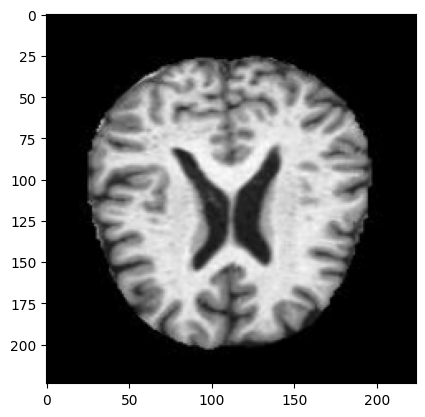

In [30]:
#test_model.summary()

img_path = "/content/sample_data/test_image2.jpg"
input_img = prep_input(img_path)
# Convert the grayscale image to RGB by stacking it 3 times
input_img = tf.concat([input_img, input_img, input_img], axis=-1)
input_img = tf.keras.applications.densenet.preprocess_input(input_img)
plt.imshow(norm_flat_image(input_img[0]), cmap = "gray")

In [31]:
class_indices = {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
class_names = {v: k for k, v in class_indices.items()}
result = test_model(input_img)
predicted_class_index = tf.argmax(result, axis=1).numpy()[0]
predicted_class_name = class_names[predicted_class_index]
print("Predicted class:", predicted_class_name)


Predicted class: VeryMildDemented


In [32]:
# Guided Backpropagation
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy > 0, tf.float32) * tf.cast(x > 0, tf.float32) * dy
    return tf.nn.relu(x), grad

In [33]:
# Modify the model to use Guided Backpropagation
layer_dict = [layer for layer in test_model.layers[1:] if hasattr(layer, 'activation')]
for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelu
        print("Changed activation of", layer.name)



In [34]:
# Compute gradients with Guided Backpropagation
with tf.GradientTape() as tape:
    tape.watch(input_img)
    result = test_model(input_img)
    max_score = result[0, predicted_class_index]
grads = tape.gradient(max_score, input_img)

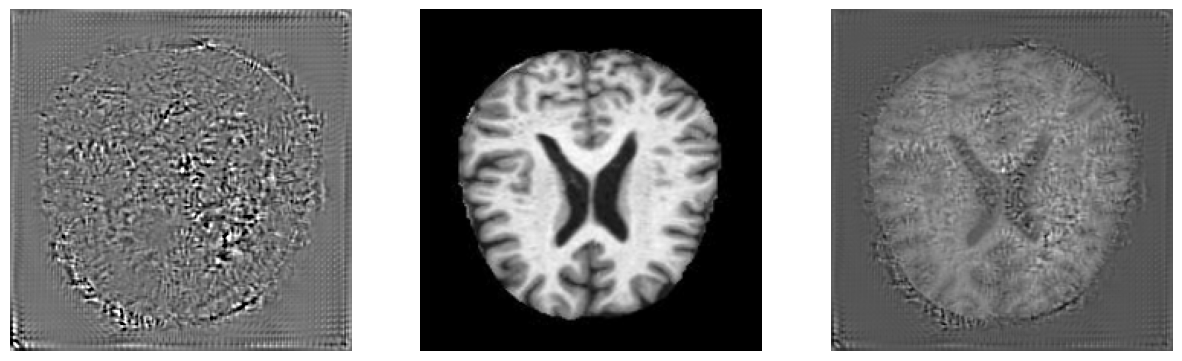

In [35]:
plot_maps(norm_flat_image(grads[0]), norm_flat_image(input_img[0]))
plt.show()

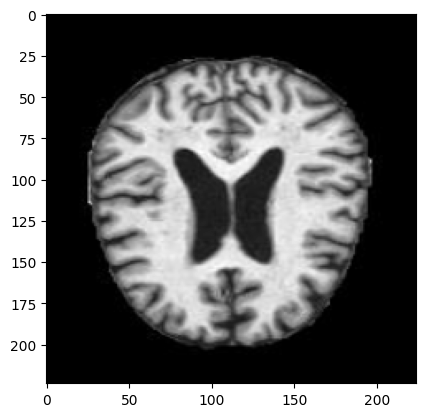

In [37]:
img_path = "/content/sample_data/test_image.jpg"
input_img = prep_input(img_path)
# Convert the grayscale image to RGB by stacking it 3 times
input_img = tf.concat([input_img, input_img, input_img], axis=-1)
input_img = tf.keras.applications.densenet.preprocess_input(input_img)
plt.imshow(norm_flat_image(input_img[0]), cmap = "gray")

In [38]:
result = test_model(input_img)
predicted_class_index = tf.argmax(result, axis=1).numpy()[0]
predicted_class_name = class_names[predicted_class_index]
print("Predicted class:", predicted_class_name)

Predicted class: VeryMildDemented


In [39]:
with tf.GradientTape() as tape:
    tape.watch(input_img)
    result = test_model(input_img)
    max_score = result[0, predicted_class_index]
grads = tape.gradient(max_score, input_img)

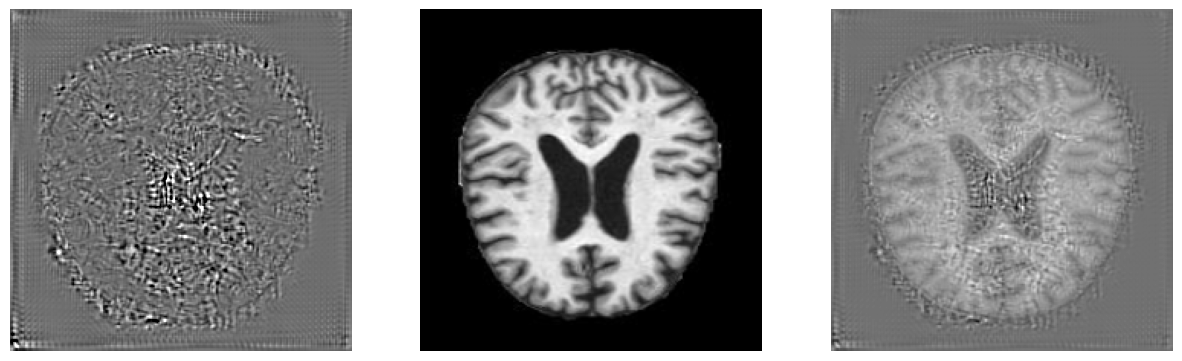

In [40]:
plot_maps(norm_flat_image(grads[0]), norm_flat_image(input_img[0]))
plt.show()